In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikanth0702","key":"4ea15bce538b966f65e78c444ceae21e"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nunenuh/pytorch-challange-flower-dataset
!unzip -q pytorch-challange-flower-dataset.zip -d flower_data

Dataset URL: https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset
License(s): CC0-1.0
 89% 295M/330M [00:01<00:00, 334MB/s]
100% 330M/330M [00:01<00:00, 293MB/s]


In [ ]:
# importing relevant libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from collections import OrderedDict
import json
import matplotlib.pyplot as plt

In [ ]:
train_images = '/content/flower_data/dataset/train'
validation_images = '/content/flower_data/dataset/valid'
test_images = '/content/flower_data/dataset/valid'

In [ ]:
# declaring the transformations to be applied on the images
# these transformations involve resizing the images to size of 224x224 which is fed into a pre-trained network
# converting the image into tensor
# normalizing the three channels of the image using the mean and standard deviation of the imagenet dataset

training_dataset_transformations = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
validation_dataset_transformations = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [ ]:
# utilizing imagefolder from torchvision as the image per label are in different folders
train_dataset = datasets.ImageFolder(train_images, transform=training_dataset_transformations)
validation_dataset = datasets.ImageFolder(validation_images, transform=validation_dataset_transformations)

In [ ]:
# declaring the dataset loaders
train_dataset_loader = DataLoader(dataset = train_dataset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(dataset = validation_dataset, batch_size=64, shuffle=True)

In [ ]:
with open('/content/flower_data/cat_to_name.json') as f:
  cat_to_name = json.load(f)

In [ ]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.0MB/s]


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)), # first layer of fully connected layer
    ('relu1', nn.ReLU()), # applying the ReLU activation function
    ('fc2',nn.Linear(4096, 102)) # output layer of the classifier
]))

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.classifier = classifier

In [ ]:
number_of_epochs = 30
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
model = model.to(device)

In [ ]:
# declring the variables for storing the losses
training_dataset_losses = []
validation_dataset_losses = []

In [ ]:
%%time
for epoch in range(number_of_epochs + 1):
  # declaring variable for keeping the track of training and validation losses
  train_loss = 0
  valid_loss = 0

  model.train()
  for data, target in train_dataset_loader:
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * data.size(0)

  model.eval()
  for data, target in validation_dataset_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    loss = criterion(output, target)
    valid_loss += loss.item() * data.size(0)

  # calculating the average losses for the whole epoch
  train_loss = train_loss/len(train_dataset_loader.dataset)
  valid_loss = valid_loss/len(validation_dataset_loader.dataset)
  training_dataset_losses.append(train_loss)
  validation_dataset_losses.append(valid_loss)

  # print training/validation statistics
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

Epoch: 0 	Training Loss: 0.797442 	Validation Loss: 0.825394
Epoch: 1 	Training Loss: 0.636523 	Validation Loss: 0.727602
Epoch: 2 	Training Loss: 0.540711 	Validation Loss: 0.758298
Epoch: 3 	Training Loss: 0.499708 	Validation Loss: 0.804204
Epoch: 4 	Training Loss: 0.473833 	Validation Loss: 0.691734
Epoch: 5 	Training Loss: 0.436950 	Validation Loss: 0.594382
Epoch: 6 	Training Loss: 0.418339 	Validation Loss: 0.742218
Epoch: 7 	Training Loss: 0.421004 	Validation Loss: 0.757943
Epoch: 8 	Training Loss: 0.411409 	Validation Loss: 0.895653
Epoch: 9 	Training Loss: 0.398596 	Validation Loss: 0.826001
Epoch: 10 	Training Loss: 0.388437 	Validation Loss: 0.752064
Epoch: 11 	Training Loss: 0.372730 	Validation Loss: 0.676307
Epoch: 12 	Training Loss: 0.361189 	Validation Loss: 0.822963
Epoch: 13 	Training Loss: 0.392514 	Validation Loss: 0.735864
Epoch: 14 	Training Loss: 0.414521 	Validation Loss: 0.761056
Epoch: 15 	Training Loss: 0.353164 	Validation Loss: 0.803969
Epoch: 16 	Trainin

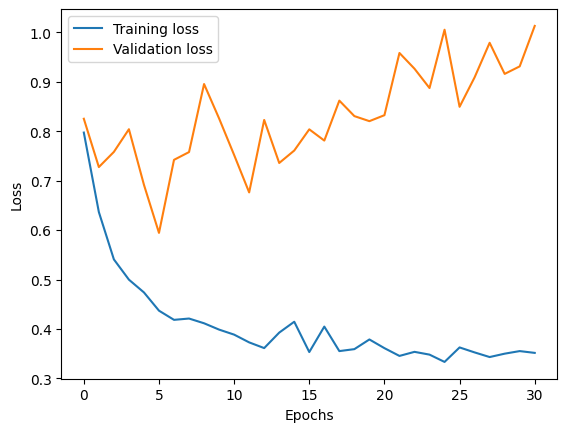

In [ ]:
plt.plot(training_dataset_losses, label='Training loss')
plt.plot(validation_dataset_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend(frameon=False)
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in validation_dataset_loader:

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 80 %
